In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

#Splits and Metrics Import
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
airbnb_data = pd.read_csv('listings.csv')

In [3]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23728 entries, 0 to 23727
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              23728 non-null  int64  
 1   name                            23674 non-null  object 
 2   host_id                         23728 non-null  int64  
 3   host_name                       23727 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   23728 non-null  object 
 6   latitude                        23728 non-null  float64
 7   longitude                       23728 non-null  float64
 8   room_type                       23728 non-null  object 
 9   price                           23728 non-null  int64  
 10  minimum_nights                  23728 non-null  int64  
 11  number_of_reviews               23728 non-null  int64  
 12  last_review                     

In [4]:
airbnb_data.shape
airbnb_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,4826,The Place,6603,Kaan,NaN,Uskudar,41.05650,29.05367,Entire home/apt,720,1,1,2009-06-01,0.01,1,365
1,20815,The Bosphorus from The Comfy Hill,78838,Gülder,NaN,Besiktas,41.06984,29.04545,Entire home/apt,816,365,41,2018-11-07,0.33,2,279
2,27271,LOVELY APT. IN PERFECT LOCATION,117026,Mutlu,NaN,Beyoglu,41.03254,28.98153,Entire home/apt,233,30,13,2018-05-04,0.19,1,289
3,28277,Duplex Apartment with Terrace,121607,Alen,NaN,Sisli,41.04471,28.98567,Hotel room,761,3,0,NaN,NaN,19,365
4,28318,Cosy home overlooking Bosphorus,121721,Aydin,NaN,Sariyer,41.09048,29.05559,Entire home/apt,823,3,0,NaN,NaN,1,88


In [5]:
airbnb_data.isnull().sum()

id                                    0
name                                 54
host_id                               0
host_name                             1
neighbourhood_group               23728
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       12375
reviews_per_month                 12375
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
print('Number of quantitative features: {}'.format(len([d for d in airbnb_data.columns if airbnb_data.dtypes[d] != 'object'])))
print('Number of qualitative features: {}'.format(len([d for d in airbnb_data.columns if airbnb_data.dtypes[d] == 'object'])))

Number of quantitative features: 11
Number of qualitative features: 5


# Data Cleaning

In [10]:
#Drop irrelevant columns
airbnb_data.drop(['name','id','host_name','host_id'], axis=1, inplace=True)

In [11]:
#Assuming that rooms cannot be rented for free, entries with price = 0 are removed so as to not have an impact on predictions.
airbnb_data.drop(airbnb_data[airbnb_data['price']==0].index, inplace=True)

In [12]:
#Remove NaN Values (neighbourhood_group and last_review are features to be dropped)
airbnb_data.drop(['neighbourhood_group', 'last_review'], axis=1, inplace=True)
#Set NaN values in reviews_per_month as mean of the column
r_mean = airbnb_data['reviews_per_month'].mean()
airbnb_data['reviews_per_month'].fillna(value=r_mean, inplace=True)

In [13]:
airbnb_data.to_csv('listings_cleaned.csv')

# Data Exploration

Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

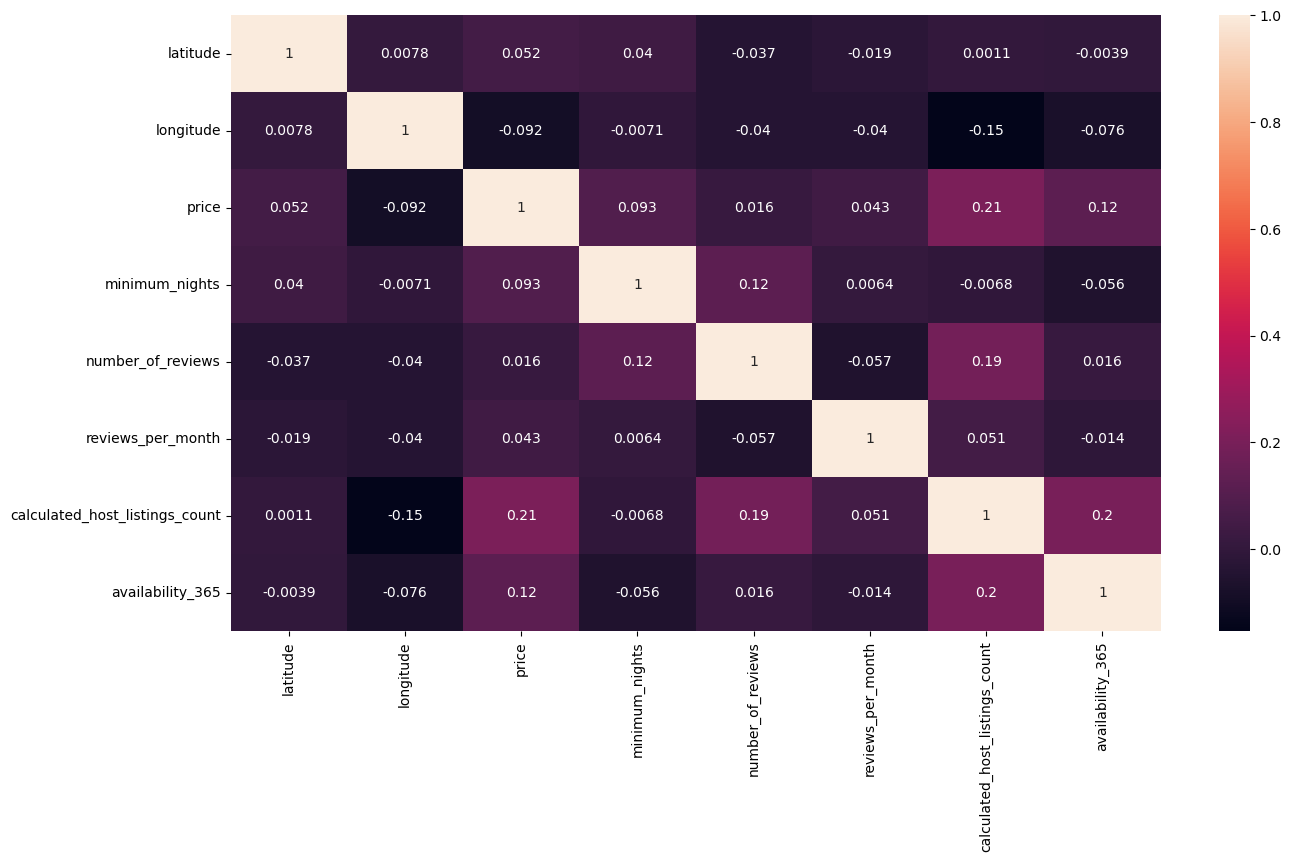

In [14]:
#Check correlations to understand important features
corr = airbnb_data.corr(method='kendall', numeric_only=True)
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
airbnb_data.columns

In [15]:
#Identifying unique entries for the feature Neighbourhood
airbnb_data['neighbourhood'].unique()

array(['Uskudar', 'Besiktas', 'Beyoglu', 'Sisli', 'Sariyer', 'Fatih',
       'Kadikoy', 'Kagithane', 'Adalar', 'Maltepe', 'Esenyurt', 'Beykoz',
       'Basaksehir', 'Bahcelievler', 'Bagcilar', 'Silivri', 'Beylikduzu',
       'Umraniye', 'Sile', 'Cekmekoy', 'Kucukcekmece', 'Sancaktepe',
       'Bakirkoy', 'Tuzla', 'Pendik', 'Atasehir', 'Kartal', 'Sultangazi',
       'Gaziosmanpasa', 'Buyukcekmece', 'Eyup', 'Zeytinburnu', 'Catalca',
       'Avcilar', 'Gungoren', 'Esenler', 'Sultanbeyli', 'Bayrampasa',
       'Arnavutkoy'], dtype=object)

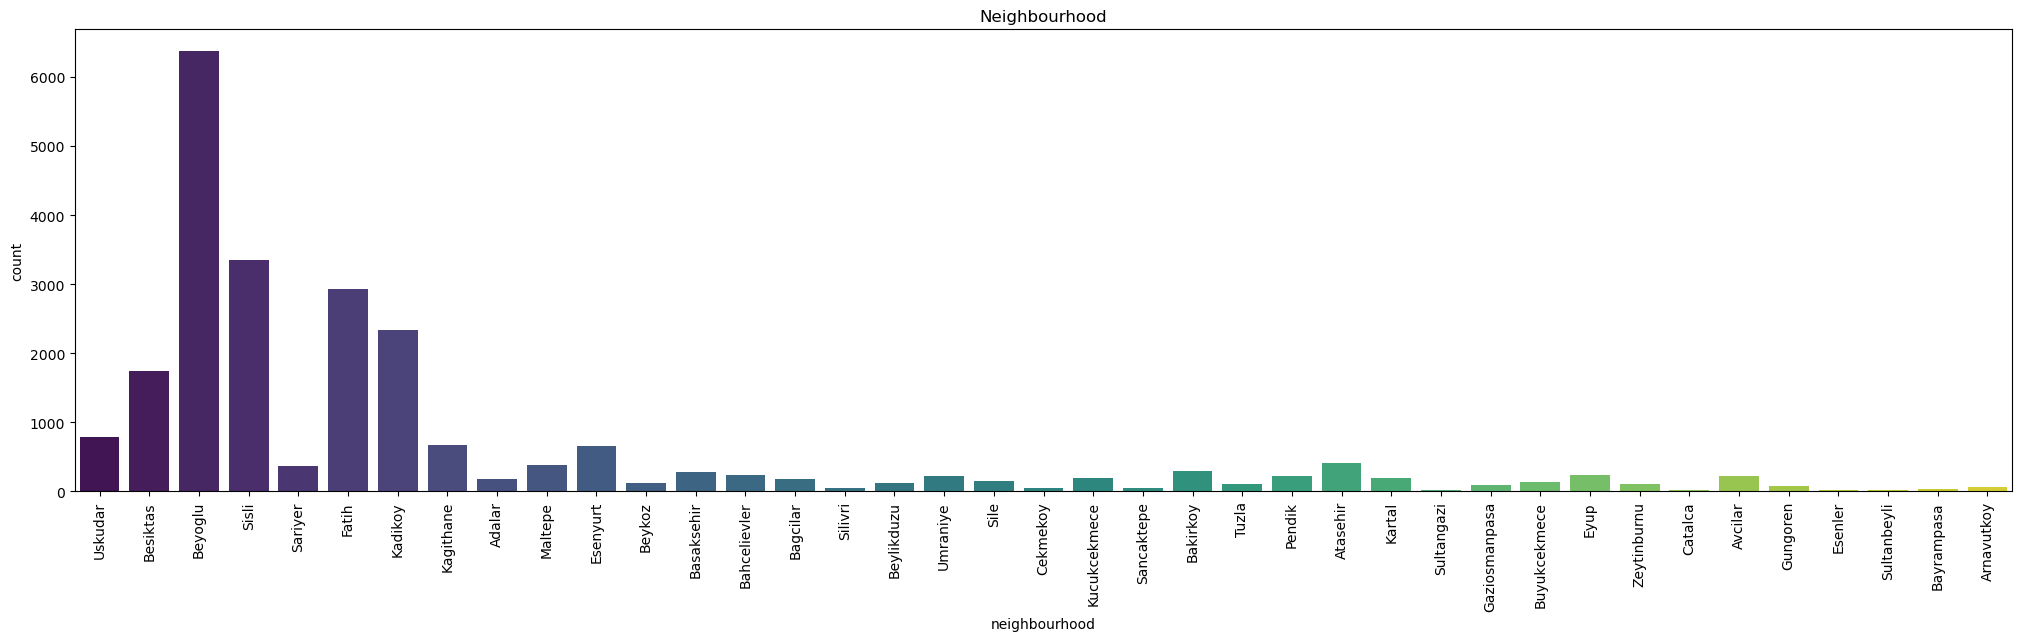

In [16]:
# Plotting the count of unique neighbourhoods
plt.figure(figsize=(25, 6))
sns.countplot(x='neighbourhood', data=airbnb_data, palette="viridis")
plt.title('Neighbourhood')
plt.xticks(rotation=90)
plt.show()

<Figure size 3000x3000 with 0 Axes>

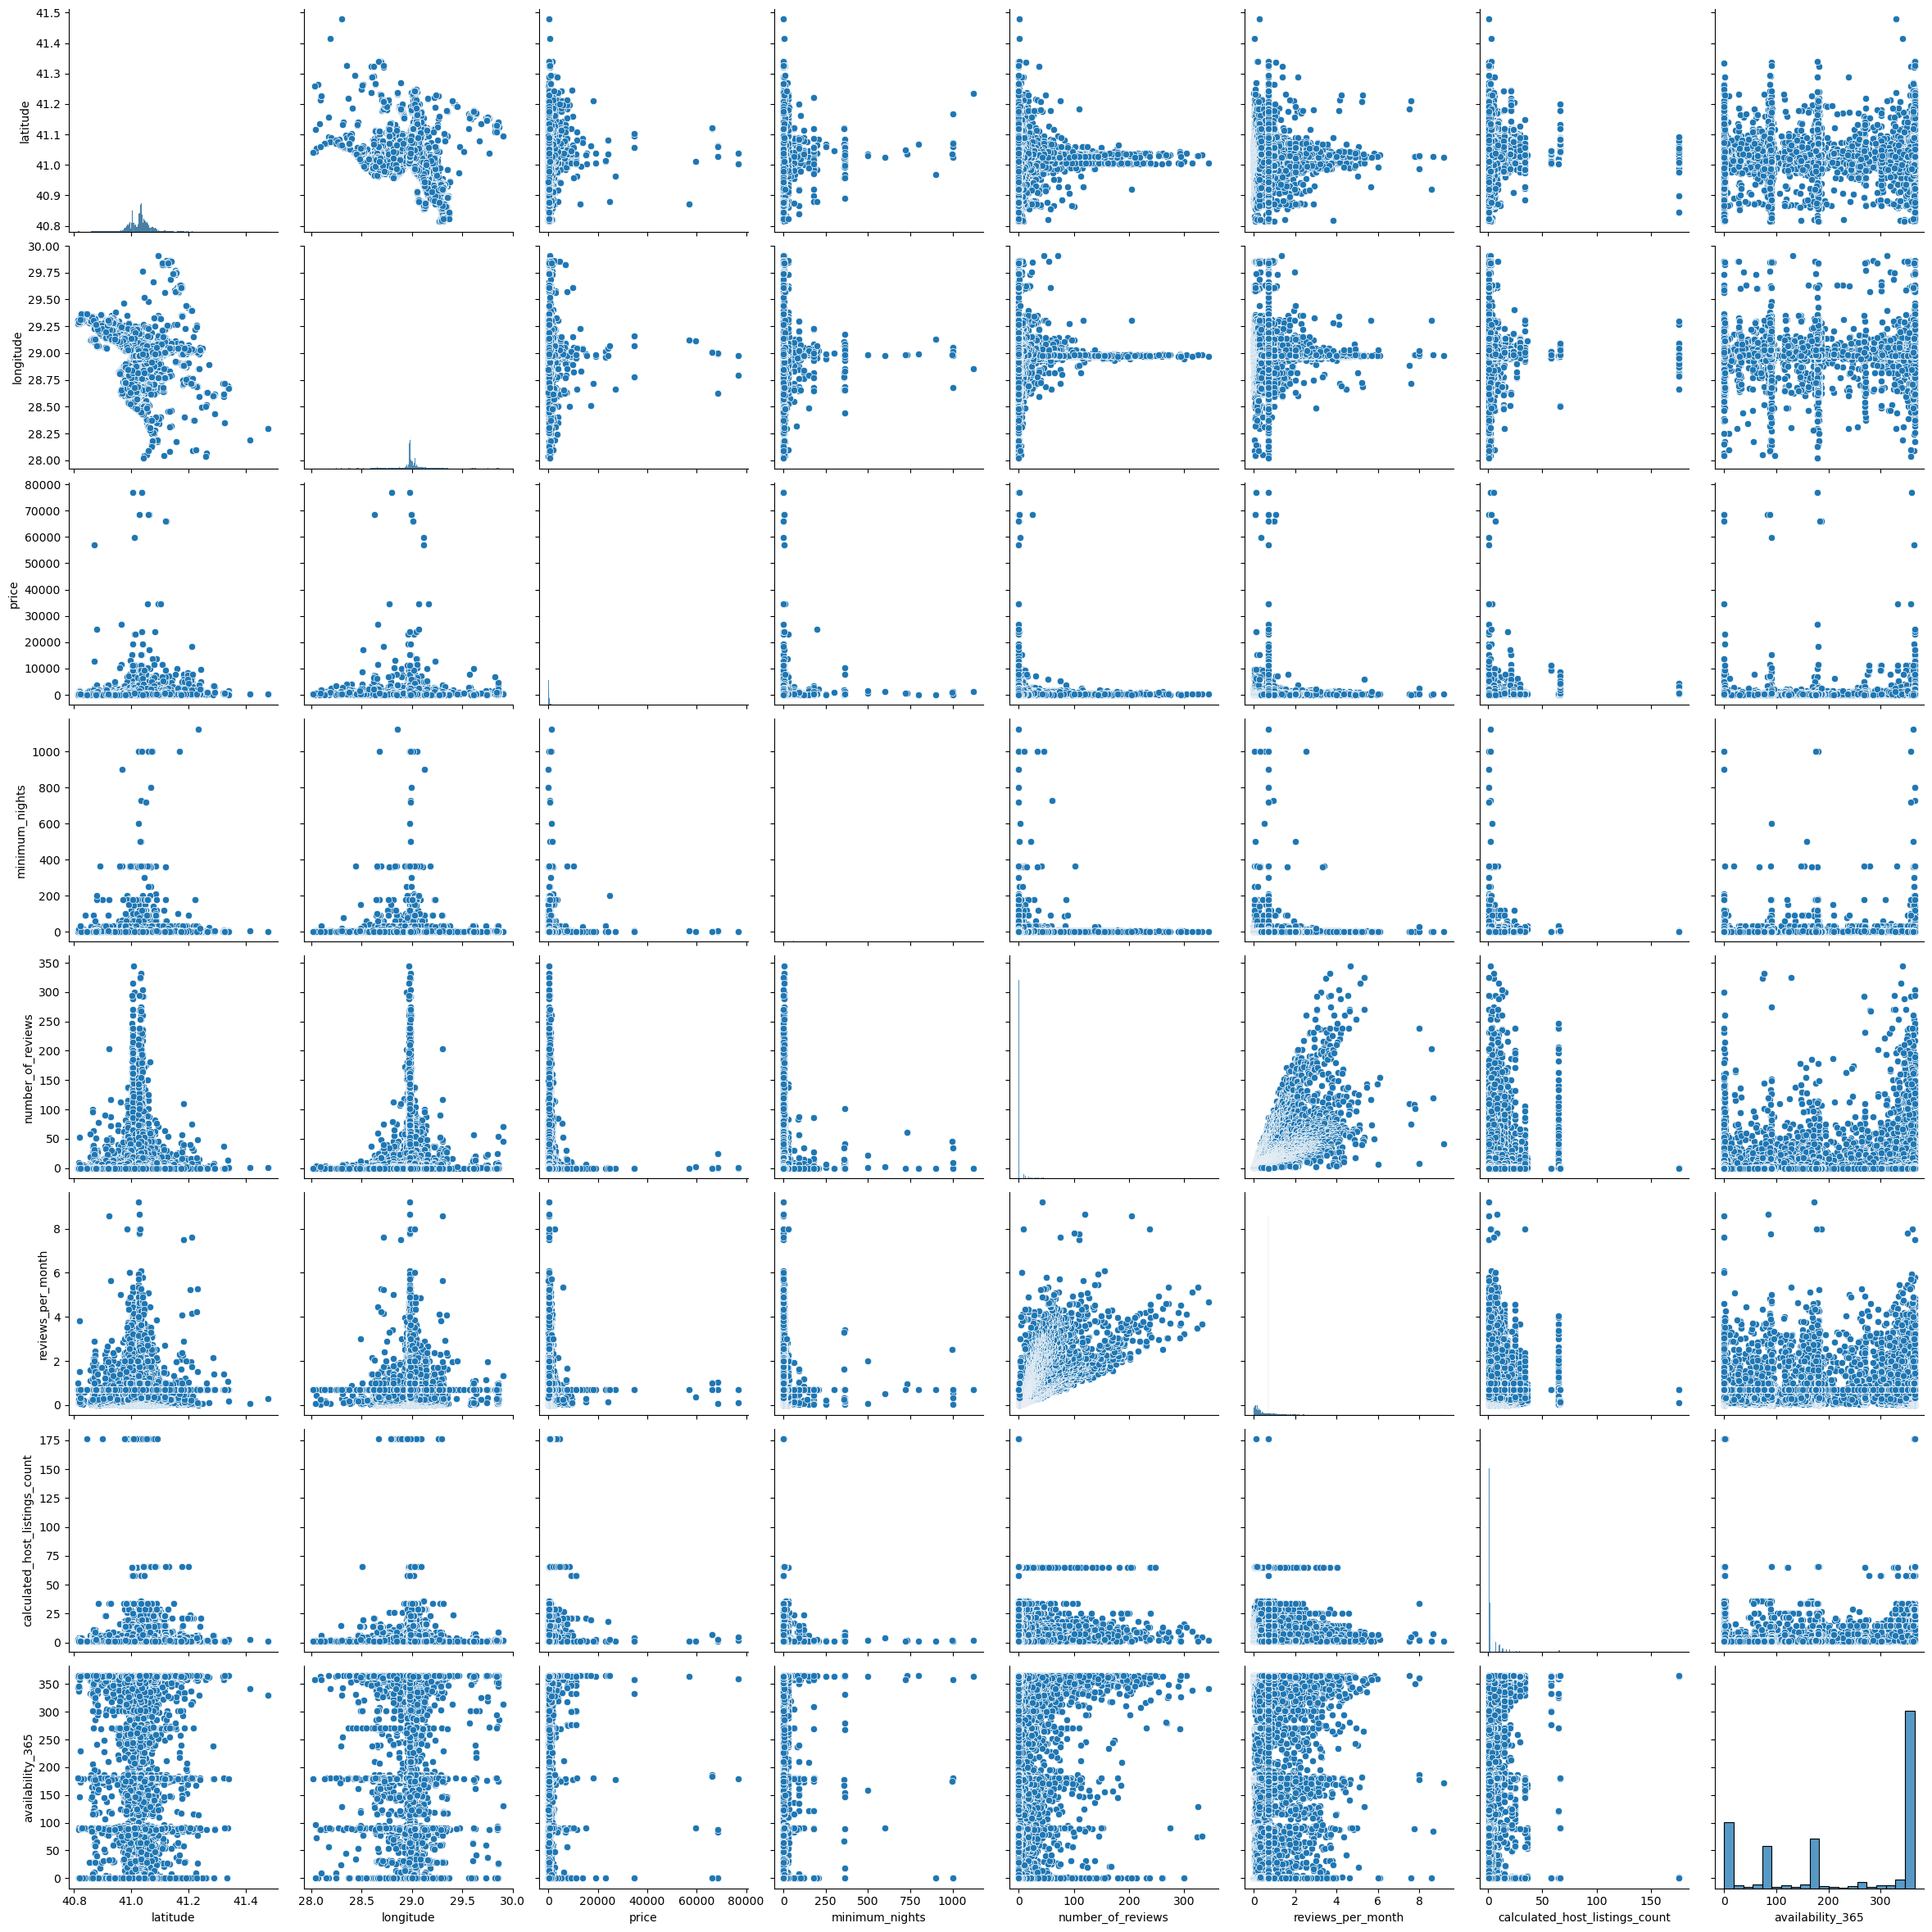

In [17]:
plt.figure(figsize=(30, 30))
sns.pairplot(airbnb_data, height=3, diag_kind="hist")

Text(0.5, 0.98, 'Price Distribution')

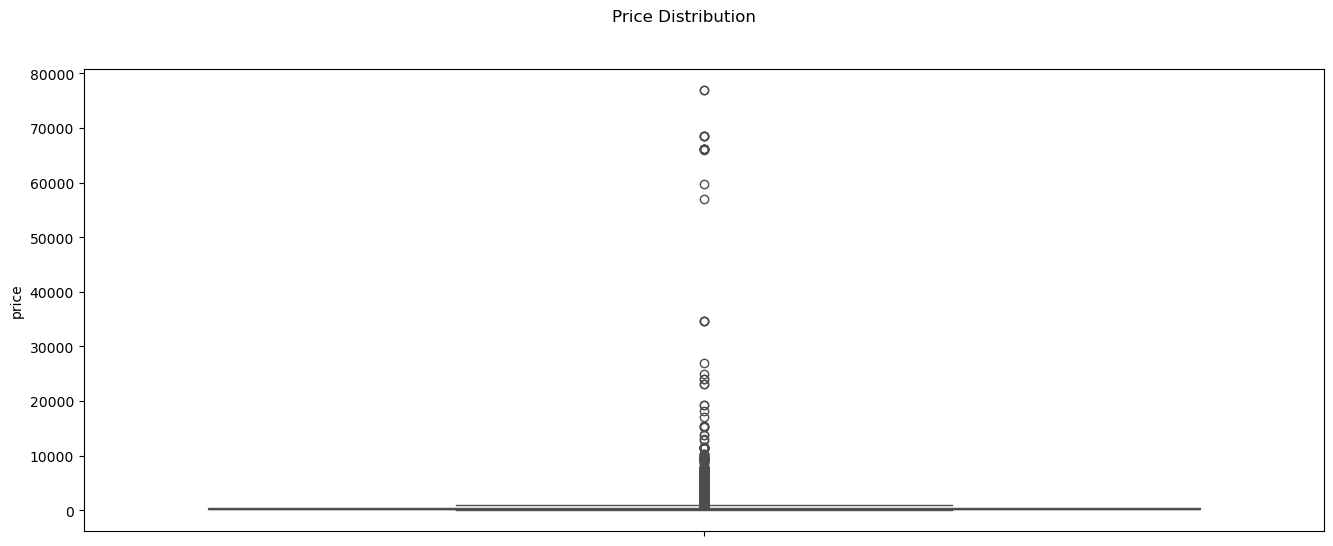

In [18]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111)
sns.boxplot(y = airbnb_data['price'], ax=ax1, color='red')
fig.suptitle('Price Distribution')

Text(0.5, 1.0, 'Room Type vs Price')

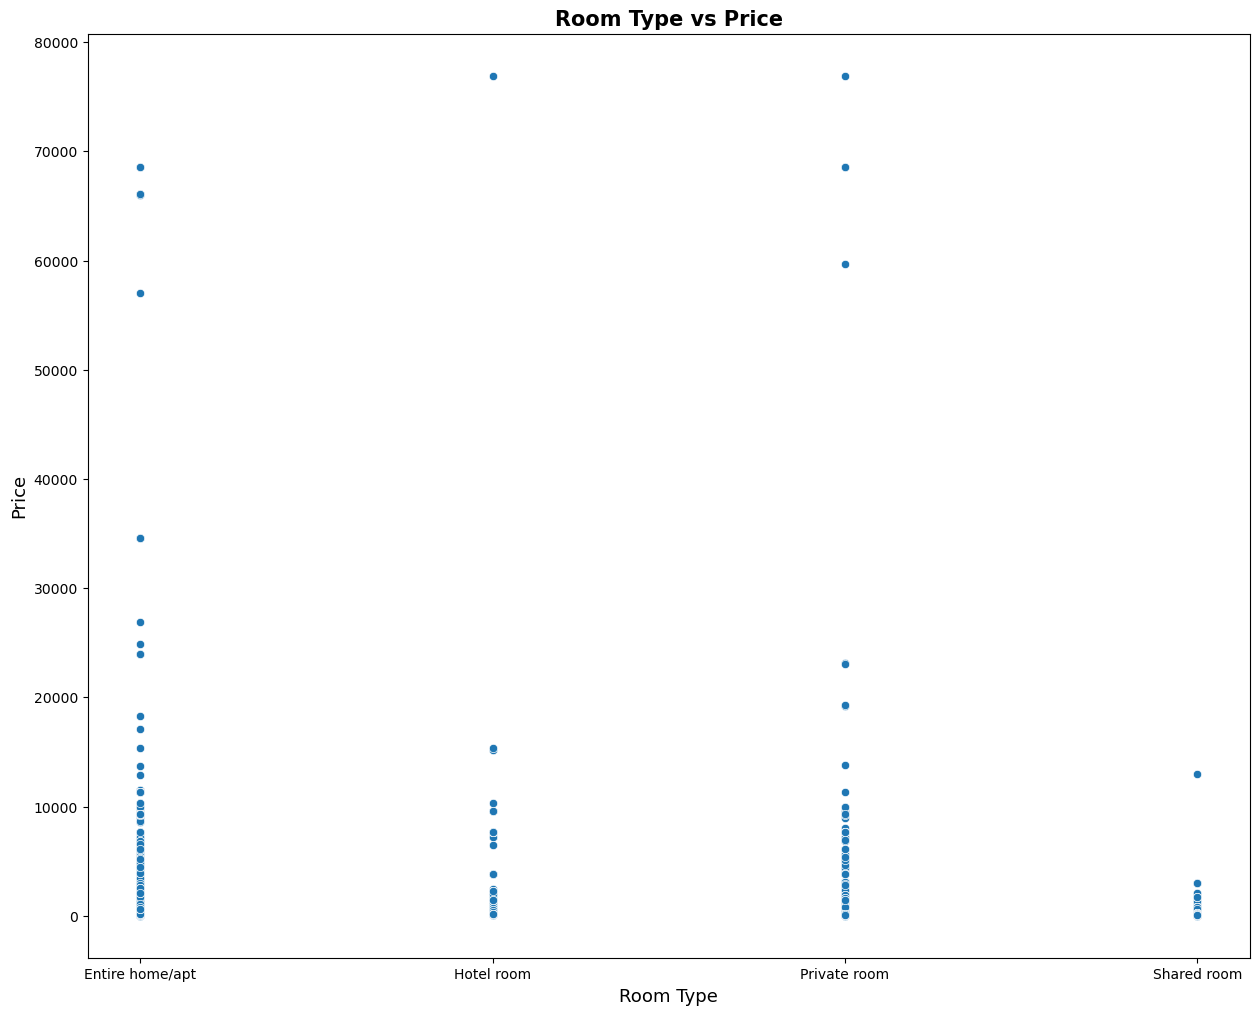

In [19]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='room_type', y='price', data=airbnb_data)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price",size=15, weight='bold')

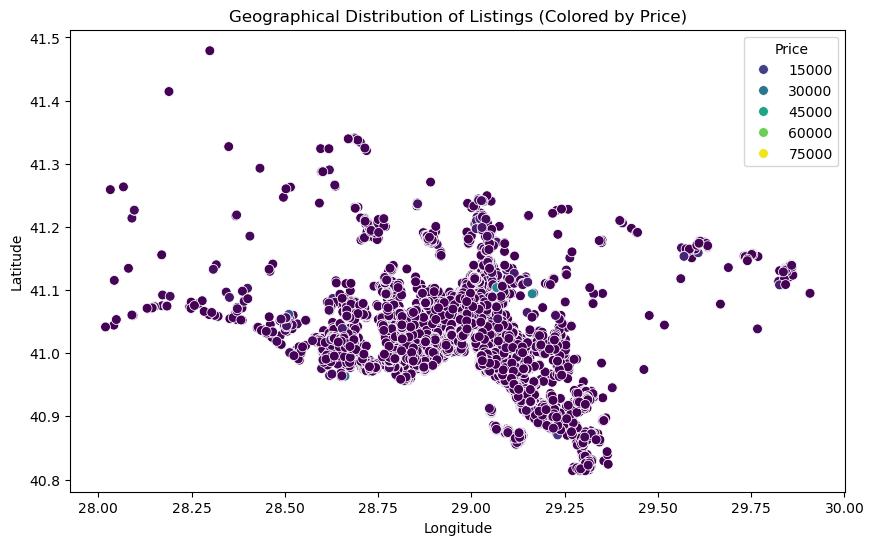

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='price', data=airbnb_data, palette='viridis', s=50)
plt.title('Geographical Distribution of Listings (Colored by Price)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price', loc='upper right')
plt.show()

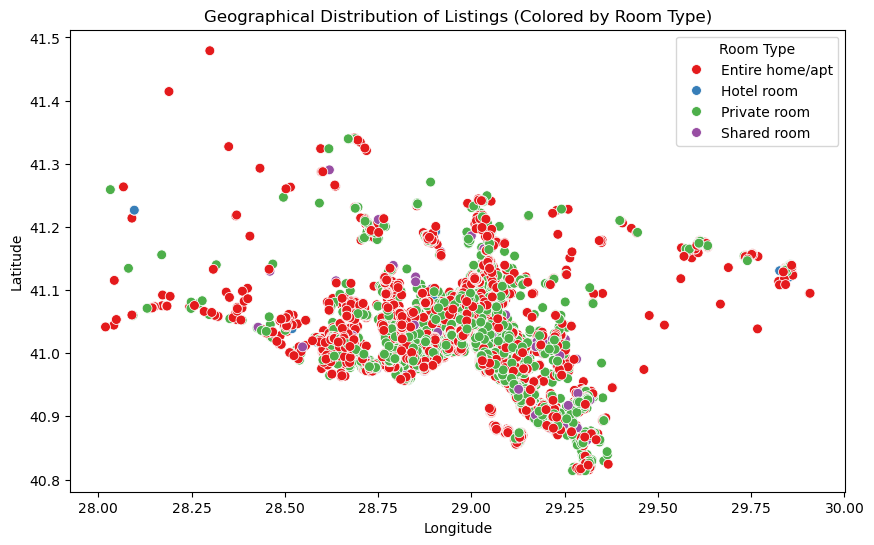

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='room_type', data=airbnb_data, palette='Set1', s=50)
plt.title('Geographical Distribution of Listings (Colored by Room Type)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Room Type', loc='upper right')
plt.show()

## Data Visualization

### Histograms and Scatter Plots
### Why Do We Need This?

1. **Understanding Data Distribution:**
   - **Charts** help visualize the distribution of numerical data, such as the price of listings. This allows us to identify patterns, such as skewness, which might necessitate data transformations.

2. **Identifying Outliers and Anomalies:**
   - **Scatter plots** can highlight outliers, which are data points that differ significantly from others. These can be clearly identified in the price vs room type and price distribution graphs.

3. **Feature Relationships:**
   - **Scatter plots** reveal relationships between variables, such as how location (latitude and longitude) affects pricing. These visualizations can suggest which features may be significant predictors in our model.
  
4. **Multivariate Relationships (Pairplot):**
   - **Pairplots** allow us to visualize the relationships between multiple features at once, making it easier to spot trends, correlations, or potential interactions between variables. This can be especially useful for identifying how different features collectively influence the target variable, `price`.

All of the above help us make an informed decision for feature engineering and subsequently modelling.

# Outlier Removal

In [22]:
#Implement Tukey's IQR method to find outliers in data
def tukey(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    IQR_upper = Q3 + 1.5 * IQR
    IQR_lower = Q1 - 1.5 * IQR
    index = df[(df[col] < IQR_lower) | (df[col] > IQR_upper)].index
    return index

In [23]:
#Removing the outliers
outlier_indices = tukey(airbnb_data, 'price')
airbnb_data.drop(outlier_indices, inplace=True)

In [24]:
print('Skewness: {}'.format(airbnb_data['price'].skew()))
#Skewness
print('Kurtosis: {}'.format(airbnb_data['price'].kurt()))
#Kurtosis

Skewness: 1.0835463800329639
Kurtosis: 0.5024726946437066


Text(0.5, 1.0, 'Room Type vs Price (Post Outlier Removal)')

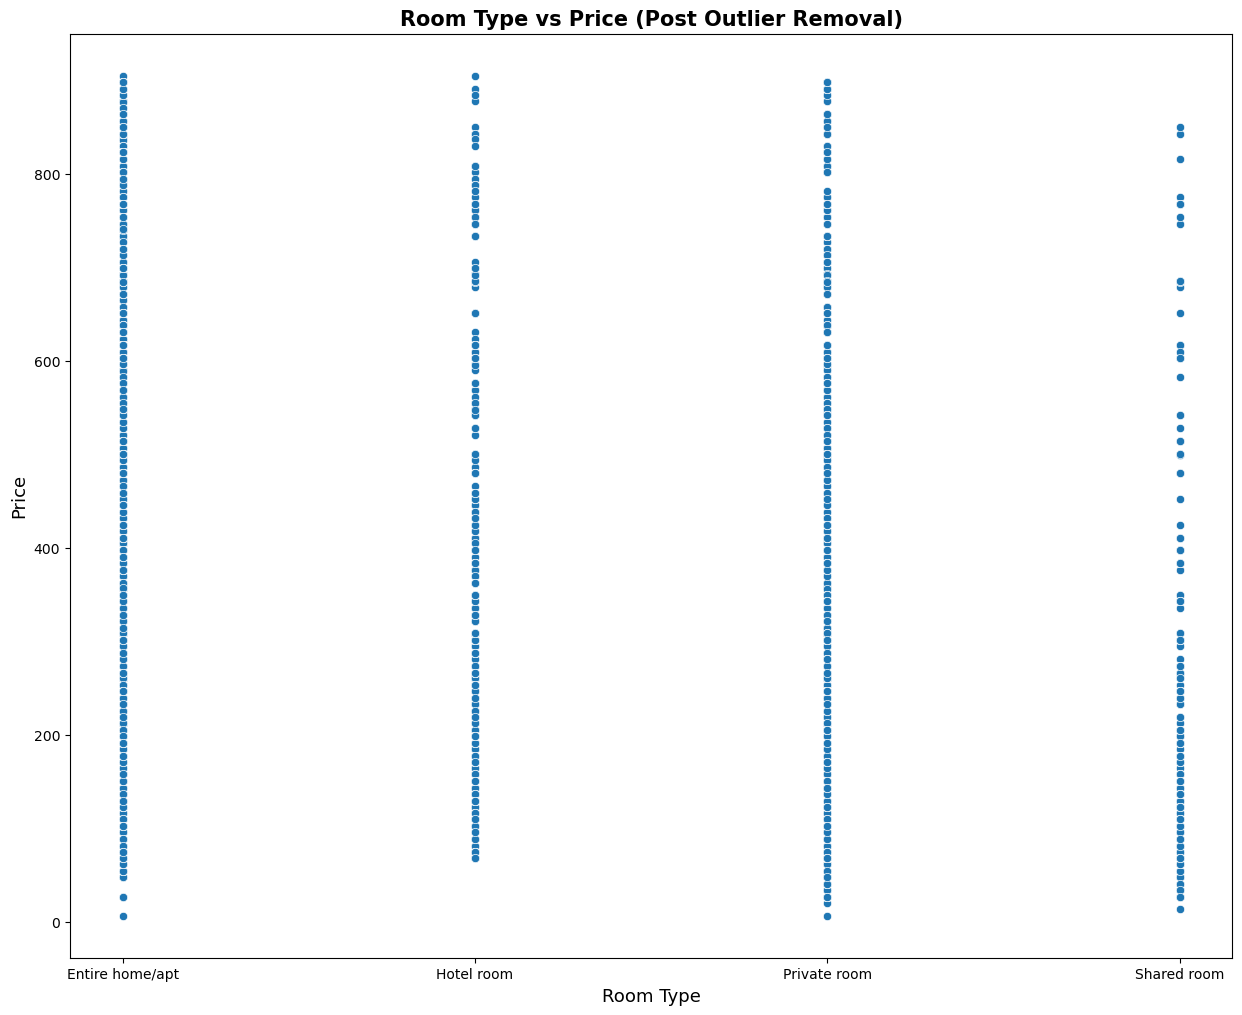

In [25]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='room_type', y='price', data=airbnb_data)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price (Post Outlier Removal)",size=15, weight='bold')

<Axes: title={'center': 'Correlation with Response Variable'}>

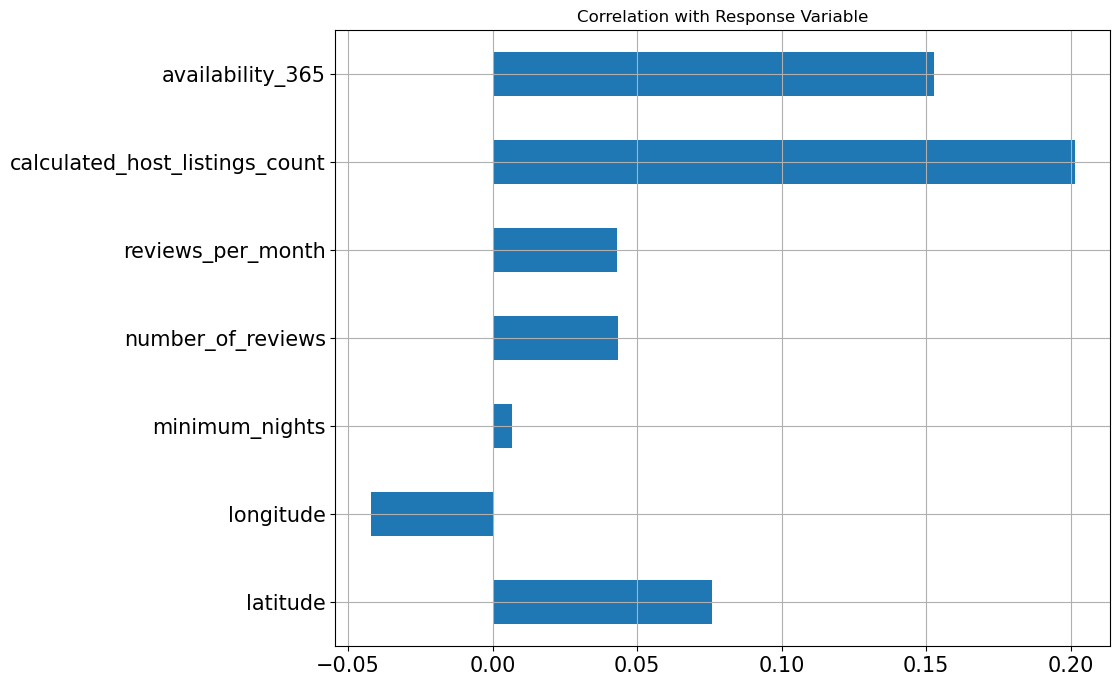

In [26]:
#Check correlation of each feature with response variable 'price'
airbnb_data.drop('price', axis=1).corrwith(airbnb_data.price, numeric_only=True).plot.barh(figsize=(10, 8), 
                                                        title='Correlation with Response Variable',
                                                        fontsize=15, grid=True)

In [27]:
#Encoding neighbourhood values
labelencoder = LabelEncoder()
airbnb_data['neighbourhood'] = labelencoder.fit_transform(airbnb_data['neighbourhood'])

In [28]:
#Apply OHE to room_type data
airbnb_data = pd.get_dummies(airbnb_data, dtype=int)

In [29]:
joblib.dump(labelencoder, 'neighbourhood_encoder.pkl')

['neighbourhood_encoder.pkl']

Index(['neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

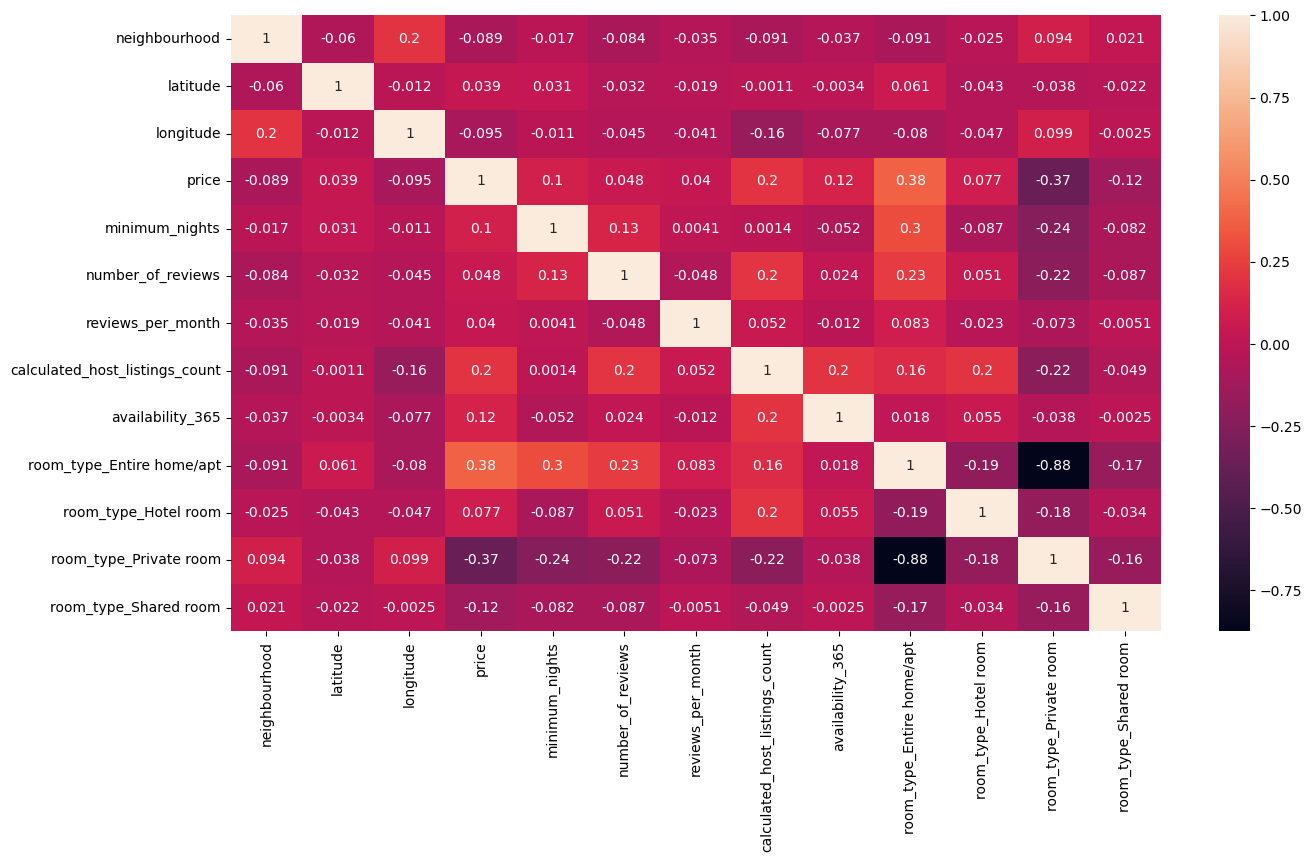

In [30]:
#Check correlations after encoding
corr = airbnb_data.corr(method='kendall', numeric_only=True)
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
airbnb_data.columns

# Models

In [31]:
#Preparing Training and Testing datasets
X = airbnb_data.drop(columns = 'price')
y = airbnb_data[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [33]:
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

['feature_names.pkl']

In [34]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))

Dimensions of the training feature matrix: (15361, 12)
Dimensions of the test feature matrix: (6584, 12)


In [35]:
#Functions to Calculate Scores

def rmse(actual, predicted):
    #Calculate the Root Mean Squared Error.
    return np.sqrt(mse(actual, predicted))

def model_scores(model, y_train, y_test, pred_train, pred_test):
    # Calculate performance metrics of the model.
    results = pd.DataFrame({
        'Model': [type(model).__name__],
        'RMSE train': [rmse(y_train, pred_train)],
        'RMSE test': [rmse(y_test, pred_test)],
        'MSE train': [mse(y_train, pred_train)],
        'MSE test': [mse(y_test, pred_test)],
        'R2 train': [r2_score(y_train, pred_train)],
        'R2 test': [r2_score(y_test, pred_test)]
    })
    results = results.round(decimals=4)
    return results

In [37]:
#Custom function to plot Predicted vs Real values.
def plot_real_vs_predicted(y_true, y_pred, num_samples=10):
    # Check if y_true is a DataFrame and extract the first column if it is
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.iloc[:, 0].values

    # Ensure both arrays are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    indices = np.arange(num_samples)
    width = 0.35  # Width of the bars

    y_true_samples = y_true[:num_samples]
    y_pred_samples = y_pred[:num_samples]

    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(indices - width/2, y_true_samples, width, label='Actual', color='royalblue')
    bars2 = ax.bar(indices + width/2, y_pred_samples, width, label='Predicted', color='lightcoral')
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.set_title('Actual vs Predicted Values')
    ax.set_xticks(indices)
    ax.set_xticklabels(indices)
    ax.legend()
    
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5,  # Adjust vertical position
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)  # Adjust fontsize
        
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5,  # Adjust vertical position
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)  # Adjust fontsize

    plt.show()

# 1. Linear Regression

In [38]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

lin_pred_train = linear_regressor.predict(X_train)
lin_pred_test = linear_regressor.predict(X_test)

linear_reg_results = model_scores(linear_regressor, y_train, y_test, lin_pred_train, lin_pred_test)

linear_reg_results.style.hide(axis='index')

Model,RMSE train,RMSE test,MSE train,MSE test,R2 train,R2 test
LinearRegression,169.302400,168.457700,28663.303900,28377.998000,0.229900,0.230000


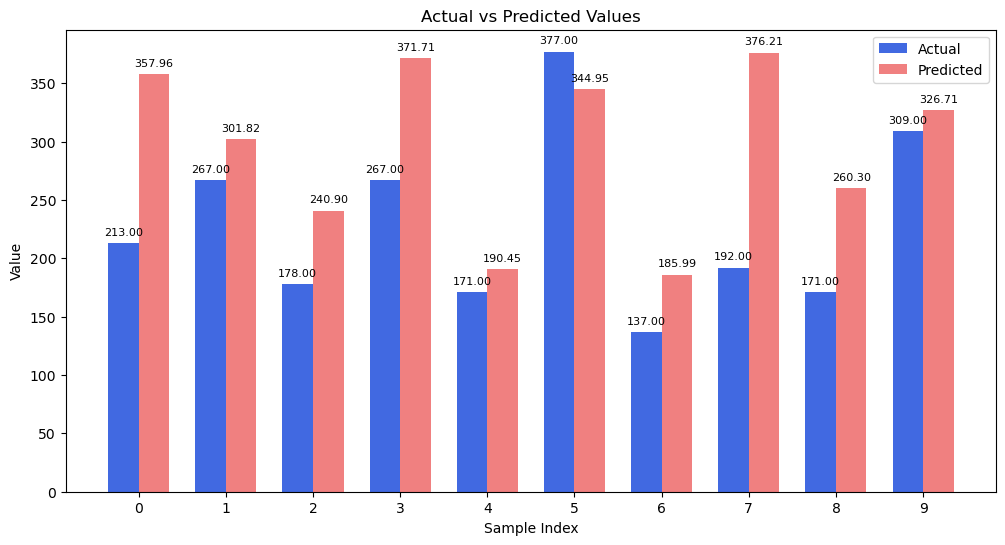

In [39]:
plot_real_vs_predicted(y_test, lin_pred_test.flatten())

# 2. Random Forest

In [40]:
# Define the parameter distributions for tuning
param_distributions = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with RandomForestRegressor
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                    param_distributions=param_distributions, 
                                    n_iter=20,
                                    scoring='neg_mean_squared_error', 
                                    cv=3, 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=42)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Retrieve the best parameters and the best model
best_params_rf = random_search.best_params_
best_model_rf = random_search.best_estimator_

print("Best parameters found: ", best_params_rf)

# Predict on the training and test data using the best model
rf_pred_train = best_model_rf.predict(X_train)
rf_pred_test = best_model_rf.predict(X_test)

#Save model for further use
joblib.dump(best_model_rf, 'rf_model.pkl') 

# Evaluate the model's performance
rf_reg_results = model_scores(best_model_rf, y_train, y_test, rf_pred_train, rf_pred_test)

# Display the results without index
rf_reg_results.style.hide(axis='index')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}


Model,RMSE train,RMSE test,MSE train,MSE test,R2 train,R2 test
RandomForestRegressor,98.763700,150.673100,9754.259200,22702.384000,0.737900,0.384000


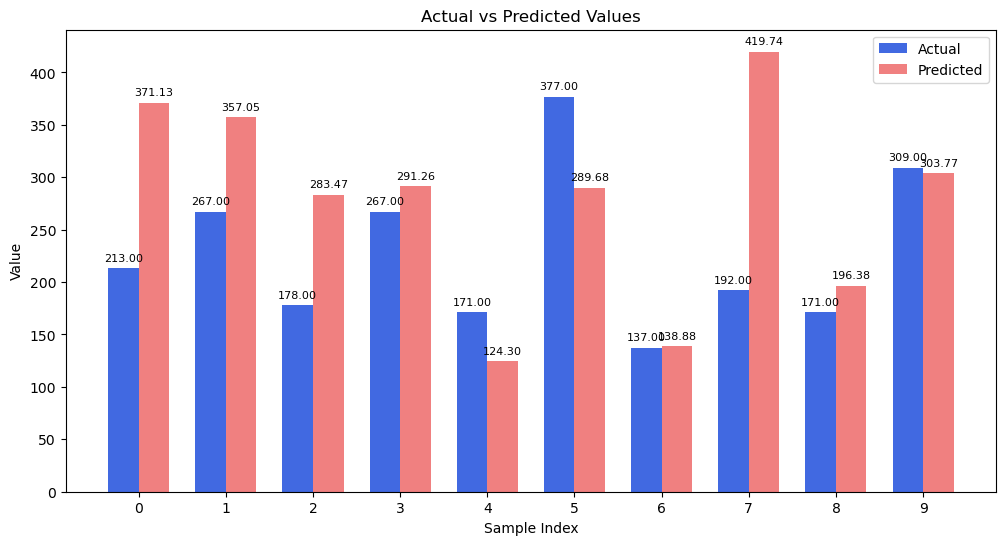

In [41]:
plot_real_vs_predicted(y_test, rf_pred_test)

## 3. XGBoost

In [42]:
# Define the parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10]
}

# Initialize GridSearchCV with XGBRegressor
grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and the best model
best_params_xgb = grid_search.best_params_
best_model_xgb = grid_search.best_estimator_

print("Best parameters found: ", best_params_xgb)

# Predict on the training and test data using the best model
xgb_pred_train = best_model_xgb.predict(X_train)
xgb_pred_test = best_model_xgb.predict(X_test)

# Evaluate the model's performance
xgb_reg_results = model_scores(best_model_xgb, y_train, y_test, xgb_pred_train, xgb_pred_test)

# Display the results without index
xgb_reg_results.style.hide(axis='index')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500}


Model,RMSE train,RMSE test,MSE train,MSE test,R2 train,R2 test
XGBRegressor,115.274000,151.756400,13288.091000,23030.003600,0.643000,0.375100


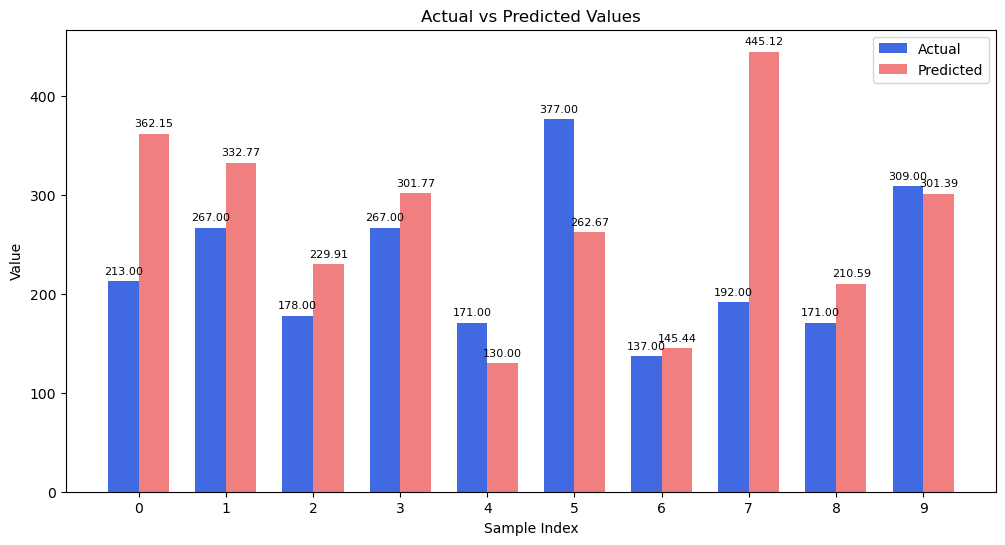

In [38]:
plot_real_vs_predicted(y_test, xgb_pred_test)

# Conclusion

**Random Forest** is the best fit model based on its performance metrics. It achieves the lowest RMSE on the training set and the highest R2 score on the training set, indicating that it captures the underlying patterns in the data better. However, it also has the highest RMSE on the test set, which suggests that it might be overfitting to the training data. Despite this, **Random Forest** still performs better than both **XGBoost** and **Linear Regression** in general.

- The limited number of data points has made it challenging to build a highly predictive model, as evidenced by the fact that multiple models trained on the same data did not yield significant improvements.
- An extended dataset with more relevant features and higher correlation could help in achieving better predictions.